Extract feature from TVDN. 


In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap
from pyTVDN import TVDNDetect

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import itertools
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [7]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");


yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}
yeo_7nets_ts = load_pkl(DATA_ROOT/"ad_ftd_hc_fmri_data_7nets.pkl");

num_rois = 246 # the BNA has 246 regions
num_sps = 321
ac_time = 485

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../data/ad_ftd_hc_fmri_data_7nets.pkl


485

In [8]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

# Run TVDN

In [9]:
tvdn_paras = edict()
# these two are most influential
tvdn_paras.fct = 0.1
tvdn_paras.lamb = 5e-5
# r is moderately influential
tvdn_paras.r = 0.8
# not very important
tvdn_paras.Lmin = 10
tvdn_paras.MaxM = 15

tvdn_paras.kappas = np.linspace(1, 2, 100)


## Get results


In [11]:
def _run_fn(sub_ix, net_ix):
    ts = yeo_7nets_ts[yeo_7nets_dict[net_ix]][sub_ix-1];
    det = TVDNDetect(Ymat=ts,
                     showProgress=False,
                     saveDir=RES_ROOT/"tvdn_7nets_res",
                     fName=f"sub_{sub_ix}_{yeo_7nets_dict[net_ix]}",
                     dataType="fMRI", 
                     MaxM=tvdn_paras.MaxM, 
                     Lmin=tvdn_paras.Lmin, 
                     fct=tvdn_paras.fct, 
                     lamb=tvdn_paras.lamb, 
                     r=tvdn_paras.r); 
    #det.Screening(wh=5)
    det()
    det.TuningKappa(tvdn_paras.kappas)
    det.UpdateEcpts()
    return det


In [ ]:
all_coms = itertools.product([5], range(1, num_sps+1))
with Parallel(n_jobs=15) as parallel:
    res = parallel(delayed(_run_fn)(sub_ix, net_ix) 
                   for net_ix, sub_ix 
                   in tqdm(all_coms, total=num_sps*1))

  5%|██████▍                                                                                                                                  | 15/321 [00:00<00:07, 43.51it/s]/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
  9%|████████████▊                                                                                                                            | 30/321 [00:03<00:38,  7.59it/s]/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  war

## Kappa find

In [13]:
def _run_fn(sub_ix, net_ix):
    ts = yeo_7nets_ts[yeo_7nets_dict[net_ix]][sub_ix-1];
    det = TVDNDetect(Ymat=ts,
                     showProgress=False,
                     saveDir=RES_ROOT/"tvdn_7nets_res",
                     fName=f"sub_{sub_ix}_{yeo_7nets_dict[net_ix]}",
                     dataType="fMRI", 
                     MaxM=tvdn_paras.MaxM, 
                     Lmin=tvdn_paras.Lmin, 
                     fct=tvdn_paras.fct, 
                     lamb=tvdn_paras.lamb, 
                     r=tvdn_paras.r); 
    #det.Screening(wh=5)
    det()
    det.TuningKappa(tvdn_paras.kappas)
    det.UpdateEcpts()
    return det


In [14]:
numchgss = []
for sub_ix in tqdm(np.where(diag_labs==6)[0]):
    det = _run_fn(sub_ix, net_ix=7)
    numchgss.append(det.numchgs)
numchgss = np.array(numchgss);

  0%|                                                                                                                                                  | 0/100 [00:00<?, ?it/s]/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


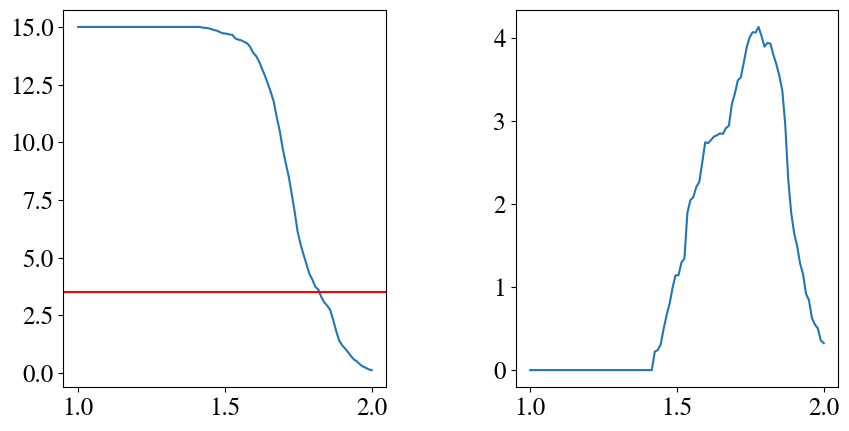

In [15]:
plt.subplot(121)
plt.plot(tvdn_paras.kappas, numchgss.mean(axis=0))
plt.axhline(y=3.5, color="red")
plt.subplot(122)
plt.plot(tvdn_paras.kappas, numchgss.std(axis=0))

In [44]:
optkp = tvdn_paras.kappas[np.argmin(np.abs(numchgss.mean(axis=0)-12.5))]
print(f"The optimal kp is {optkp:.3f}.")

The optimal kp is 1.646.


## Get features

In [27]:
net_ix = 7
rks = []
for sub_ix in trange(1, num_sps+1):
    det = _run_fn(sub_ix, net_ix)
    rks.append(det.midRes.r)
save_pkl(RES_ROOT/f"tvdn_ranks_{yeo_7nets_dict[net_ix]}.pkl", rks)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:31<00:00, 10.11it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_ranks_Default.pkl


In [39]:
net_ix = 7
ecptss = []
for sub_ix in trange(1, num_sps+1):
    det = _run_fn(sub_ix, net_ix)
    det.UpdateEcpts(det.numchgs[tvdn_paras.kappas==optkp][0])
    ecptss.append(det.ecpts)
save_pkl(RES_ROOT/f"tvdn_ecptss_kp{optkp*1000:.0f}_{yeo_7nets_dict[net_ix]}.pkl", ecptss)

  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:32<00:00,  9.76it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_ecptss_kp1727_Default.pkl


# Analyze

In [45]:
rks = np.array(load_pkl(RES_ROOT/"tvdn_ranks_Default.pkl"));
ecptss = load_pkl(RES_ROOT/f"tvdn_ecptss_kp1646_Default.pkl")
ncpts = np.array([len(ecpts) for ecpts in ecptss]);

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_ranks_Default.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_ecptss_kp1646_Default.pkl


In [46]:
res_df = pd.DataFrame({
    "metric": rks, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
_get_test_tb(res_df)

Test,Pval,Effect size
*AD vs HC,0.036,-0.311
bvFTD vs HC,0.491,-0.128
CBS vs HC,0.878,-0.033
nfvPPA vs HC,0.709,0.074
svPPA vs HC,0.187,0.254
Dementia vs HC,0.444,-0.092
ANOVA,0.082,


In [47]:
res_df = pd.DataFrame({
    "metric": ncpts, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
_get_test_tb(res_df)

Test,Pval,Effect size
*AD vs HC,0.009,-0.388
bvFTD vs HC,0.368,-0.167
CBS vs HC,0.952,0.013
nfvPPA vs HC,0.895,-0.026
svPPA vs HC,0.371,0.172
Dementia vs HC,0.172,-0.164
*ANOVA,0.027,


In [48]:
res_df.groupby("diagnosis1")["metric"].describe()

,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.060976,4.495121,0.0,11.0,13.0,14.0,15.0
CBS,27.0,12.555556,2.025479,4.0,12.0,13.0,14.0,14.0
HC,100.0,12.520000,2.862082,2.0,12.0,13.0,14.0,15.0
bvFTD,41.0,12.024390,3.181885,2.0,12.0,13.0,14.0,15.0
nfvPPA,34.0,12.441176,3.377207,3.0,13.0,14.0,14.0,15.0
svPPA,37.0,13.000000,2.527625,0.0,13.0,14.0,14.0,15.0
